<a href="https://colab.research.google.com/github/encoras/Camera_calibration/blob/main/cam_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[link text](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html)

What is Camera Calibration?
Think of camera calibration like getting your eyes checked at an optometrist. Just as an eye doctor measures how your eyes process visual information, camera calibration helps us understand how a camera transforms the 3D world into 2D images. This understanding is crucial for applications ranging from smartphone photography to self-driving cars.

At its core, camera calibration relies on a surprisingly elegant mathematical equation: x = PX
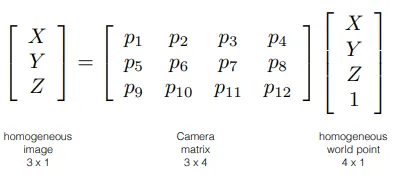

Vector representation of x = PX
x represents the 2D point in your image
P is the camera matrix (containing all camera parameters)
X represents the 3D point in the real world
Think of the camera matrix P as your camera's personal "recipe" for converting 3D scenes to 2D images. This matrix contains two crucial sets of ingredients:

1. Intrinsic Parameters (The Camera’s “Personality”)
Focal Length: How “zoomed in” your view is
Principal Point: Where the center of the image truly lies
Skew: How the pixels are shaped and aligned
Aspect Ratio: The relationship between pixel width and height
2. Extrinsic Parameters (The Camera’s “Position”)
Rotation: Which way the camera is pointing
Translation: Where the camera is located in space
Why Do We Need Camera Calibration?
Imagine trying to measure the distance between two buildings using only a photograph. Without proper calibration, you might get completely wrong measurements! Here’s why camera calibration matters:

Lens Distortion Correction: Ever noticed how wide-angle selfies make faces look slightly warped? That’s lens distortion at work.
Accurate Measurements: Essential for industries like manufacturing and construction.
Enhanced Computer Vision: Helps AI systems accurately interpret the world through cameras.
Improved Augmented Reality: Makes virtual objects align properly with the real world.

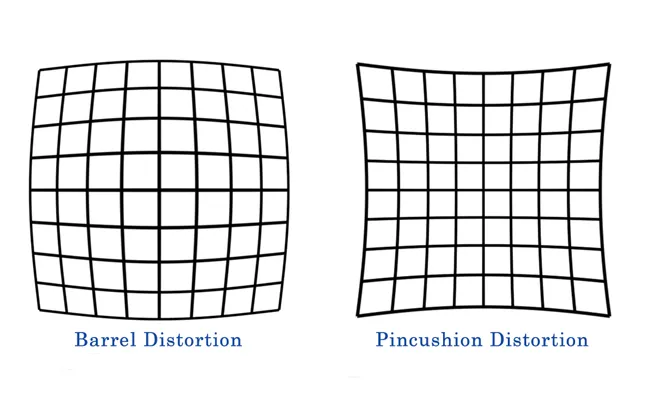
Different types of lens distortion affect an image


How to Calibrate Your Camera:
 A Step-by-Step Guide
To calibrate a camera, follow these steps:

1. Prepare a Calibration Target: The most common target used is a chessboard pattern. You can print this pattern on paper or use a physical board with squares of known dimensions.





**Chessboard Pattern**

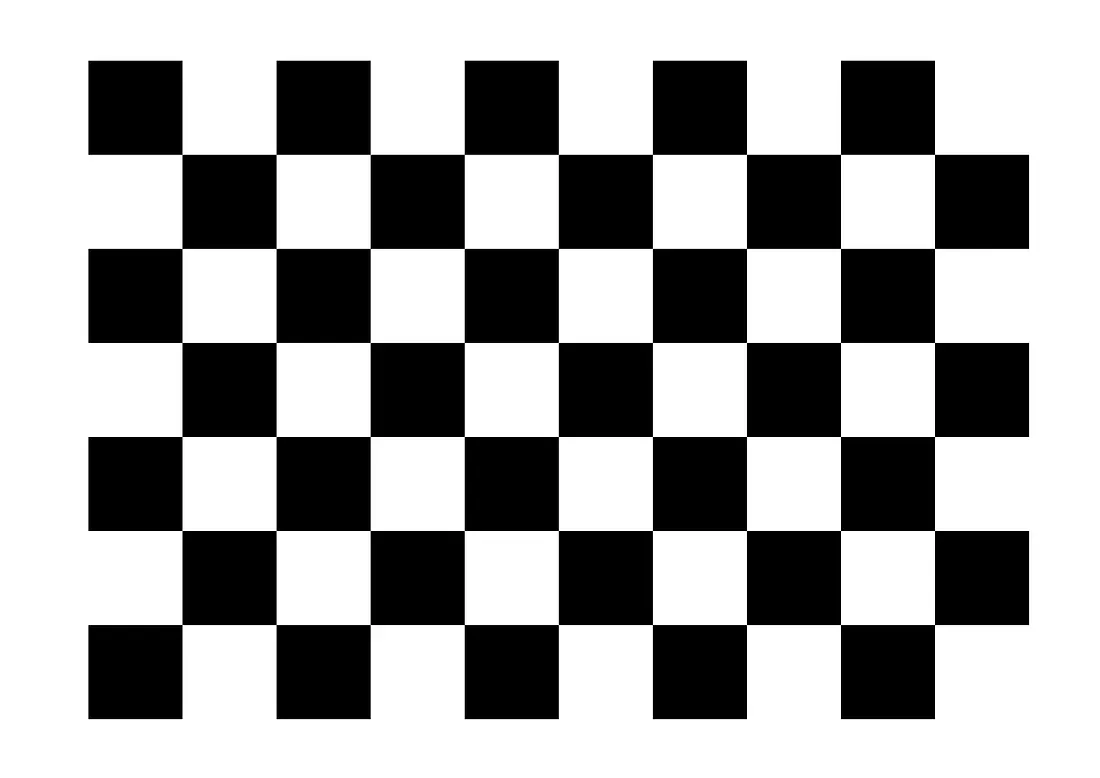

https://www.youtube.com/watch?v=Wcnb197g2i0

https://www.youtube.com/watch?v=bs81DNsMrnM

In [67]:
import cv2
import numpy as np
import glob
from google.colab.patches import cv2_imshow  # Add this import

# Termination criteria for corner sub-pixel accuracy
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)

# Prepare object points (3D points in real-world space)
objp = np.zeros((6*9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points
objpoints = []  # 3D point in real-world space
imgpoints = []  # 2D points in image plane

# Load images
images = glob.glob('/content/drive/MyDrive/Colab Notebooks/board/*.jpg')  # Update with your path

for fname in images:  # fname is the string path
    img_color = cv2.imread(fname)  # Original color image

    gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)

        # Visualize on copy of color image
        vis_img = cv2.drawChessboardCorners(img_color.copy(), (9, 6), corners2, ret)


        # Save using ORIGINAL filename (string)
        output_path = fname.replace('.jpg', '_corners.png')
        cv2.imwrite(output_path, vis_img)
        print(f"Saved: {output_path}")




# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Camera matrix:\n", mtx)
print("Distortion coefficients:\n", dist)

Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_37_Pro_corners.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_35_Pro_corners.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_36_Pro_corners.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_39_Pro_corners.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_40_Pro_corners.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_41_Pro_corners.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_42_Pro_corners.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_42_Pro (2)_corners.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_43_Pro_corners.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_44_Pro_corners.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_45_Pro_corners.png
Saved:

In [68]:
print(f"RMS Reprojection Error: {ret:.4f} pixels")  # <0.5px = excellent, <1.0px = good

RMS Reprojection Error: 0.2609 pixels


In [69]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.031515991949673736


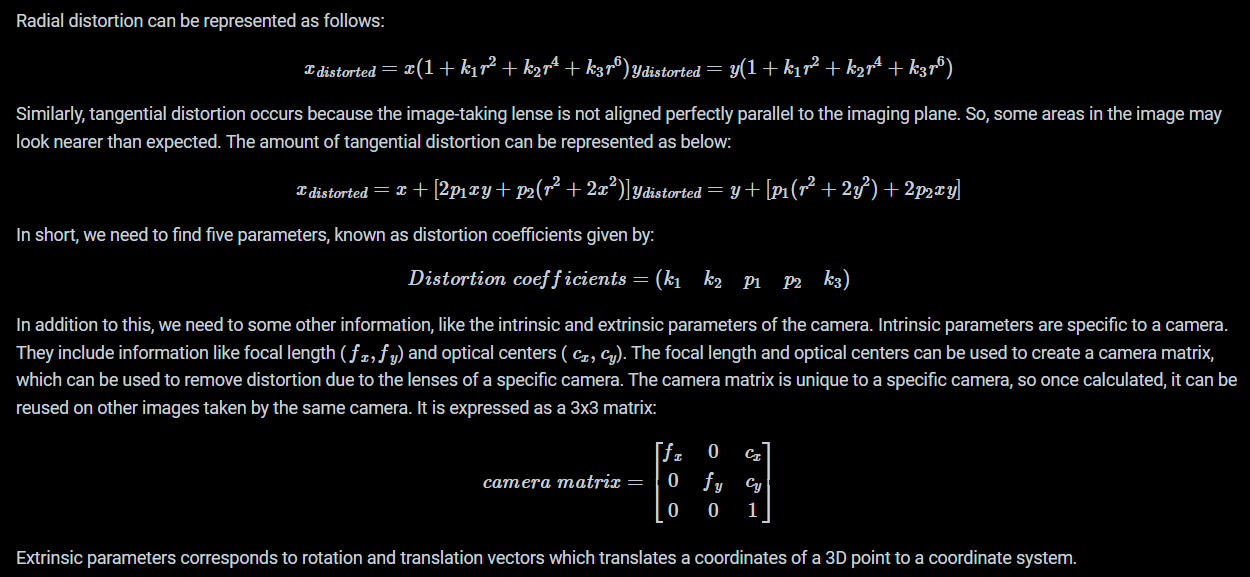

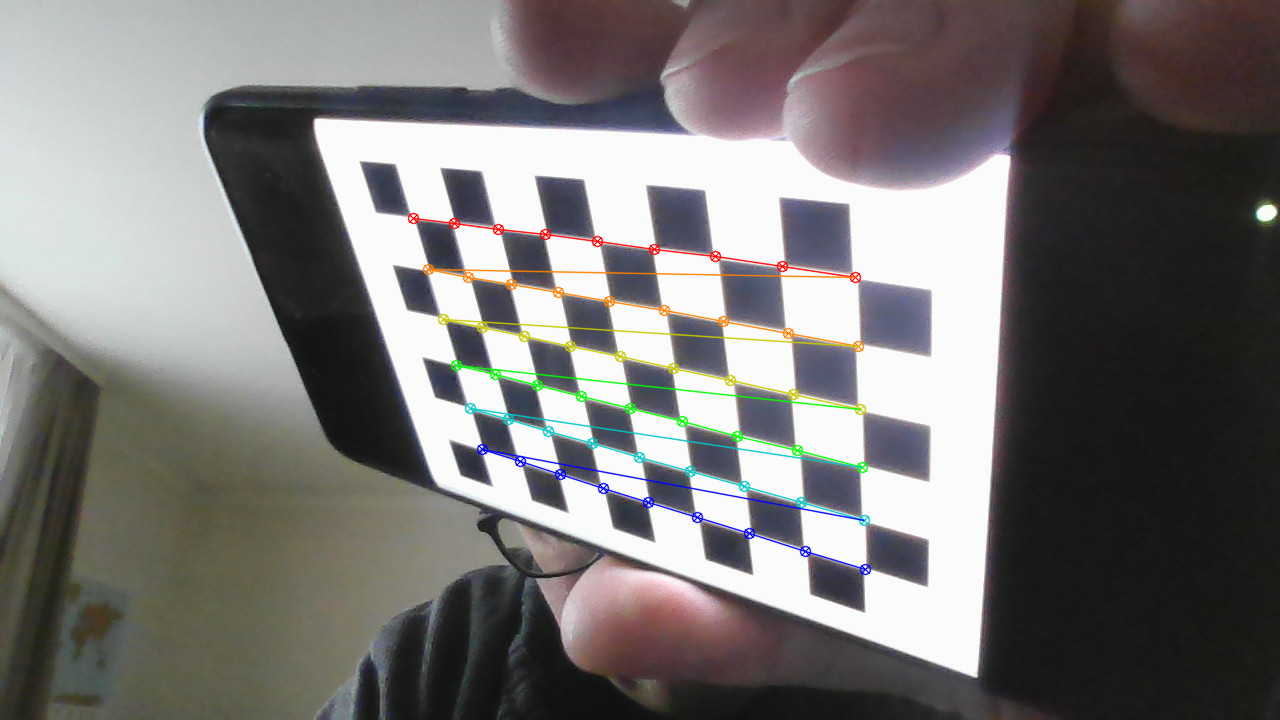

In [70]:
cv2_imshow(vis_img)

In [71]:
np.savez('/content/drive/MyDrive/Colab Notebooks/board/calibration_data.npz', mtx=mtx, dist=dist)
print("Saved calibration to calibration_data.npz")

Saved calibration to calibration_data.npz


Let's do the Undistortion

In [72]:
# Get image size from last gray (or standardize)
h, w = gray.shape[:2]
new_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

for fname in images:
    img = cv2.imread(fname)

    undistorted = cv2.undistort(img, mtx, dist, None, new_mtx)
    x, y, roi_w, roi_h = roi
    undistorted_cropped = undistorted[y:y+roi_h, x:x+roi_w]

    # Save with _undistorted suffix
    output_name = fname.replace('.jpg', '_undistorted.png')
    cv2.imwrite(output_name, undistorted_cropped)
    print(f"Saved: {output_name}")

Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_37_Pro_undistorted.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_35_Pro_undistorted.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_36_Pro_undistorted.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_39_Pro_undistorted.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_40_Pro_undistorted.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_41_Pro_undistorted.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_42_Pro_undistorted.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_42_Pro (2)_undistorted.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_43_Pro_undistorted.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_20260203_16_46_44_Pro_undistorted.png
Saved: /content/drive/MyDrive/Colab Notebooks/board/WIN_

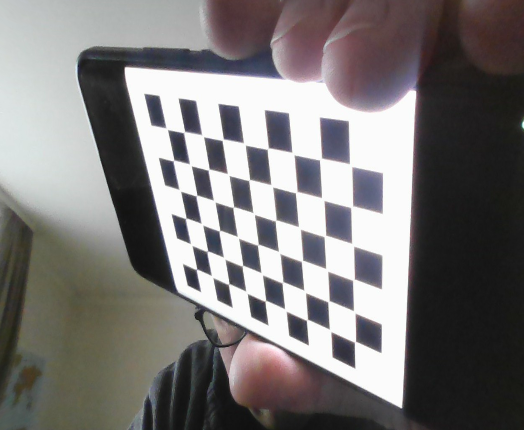

In [73]:
cv2_imshow(undistorted_cropped)

In [74]:
# Pick first image with corners (or any)
test_img = cv2.imread(images[-1])


gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
if ret:
    corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

    # Get pose (rvec, tvec already from calibration, or solvePnP)
    success, rvec, tvec = cv2.solvePnP(objp, corners2, mtx, dist)

    # Convert rotation vector → full rotation matrix
    R, _ = cv2.Rodrigues(rvec)

    # Plane normal = Z-axis of camera coordinate system (0,0,1)
    normal_cam = np.array([0, 0, 1])
    normal_world = np.linalg.inv(R) @ normal_cam  # Transform to world

    print(f"Chessboard plane normal: [{normal_world[0]:.3f}, {normal_world[1]:.3f}, {normal_world[2]:.3f}]")

Chessboard plane normal: [-0.526, 0.525, 0.669]


In [75]:
square_size =  0.0083  # 25mm = 0.025 meters
objp = np.zeros((6*9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) * square_size  # Now in METERS

Distance to chessboard: 0.128m (12.8cm)


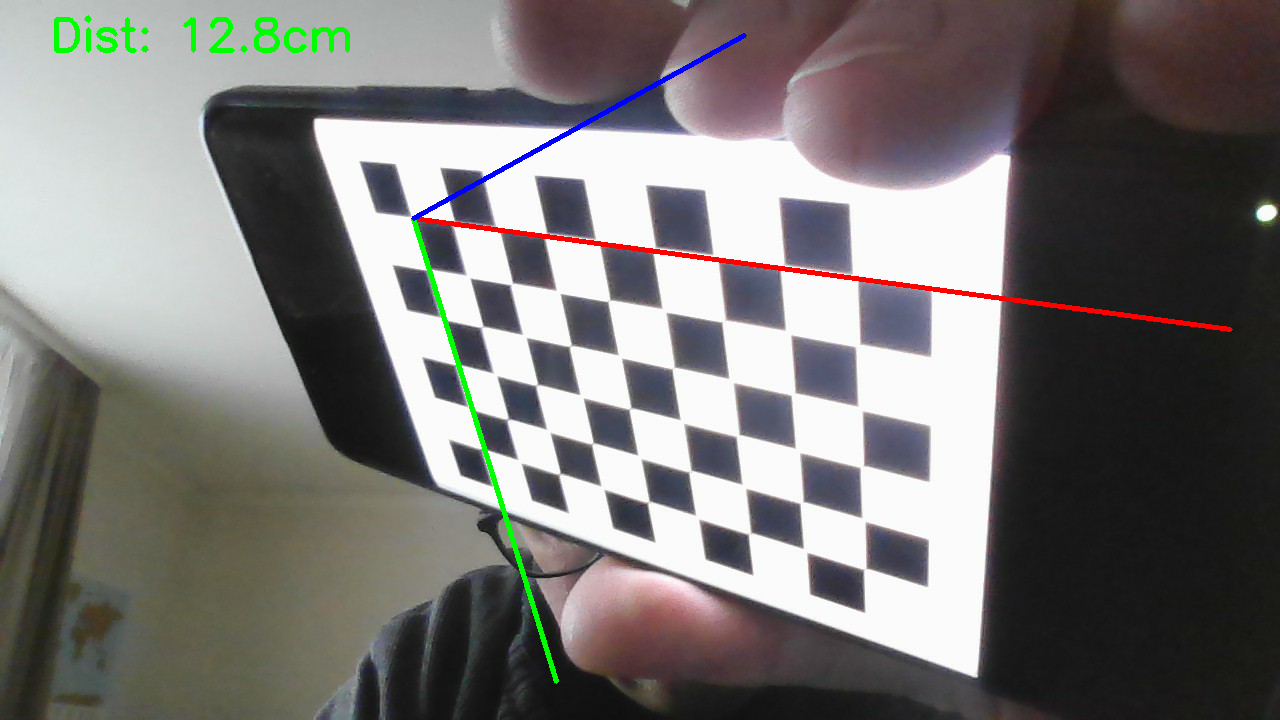

In [76]:

# Test on any image
test_img = cv2.imread(images[-1])

gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

if ret:
    corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

    # Get 6DOF pose
    success, rvec, tvec = cv2.solvePnP(objp, corners2, mtx, dist)

    distance_m = tvec[2][0]  # Z-component = distance to chessboard plane
    distance_cm = distance_m * 100

    print(f"Distance to chessboard: {distance_m:.3f}m ({distance_cm:.1f}cm)")

    # Visualize axes + distance

    img_with_axes = cv2.drawFrameAxes(test_img.copy(), mtx, dist, rvec, tvec, 0.1)
    cv2.putText(img_with_axes, f'Dist: {distance_cm:.1f}cm', (50, 50),
            cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
    cv2_imshow(img_with_axes)  # Displays inline with distance text + 3D axes


**Undistortion**: Corrects lens distortion using your calibration matrices.

**Corner Detection**: Re-detects corners in the undistorted image for accuracy.

**Homography**: Maps detected (possibly skewed) corners to a perfect rectangular grid.

**Warp**: Applies perspective transform to "unwrap" the board into a frontal view.

**Output**: A straight, top-down view of the chessboard, as if viewed perpendicularly.

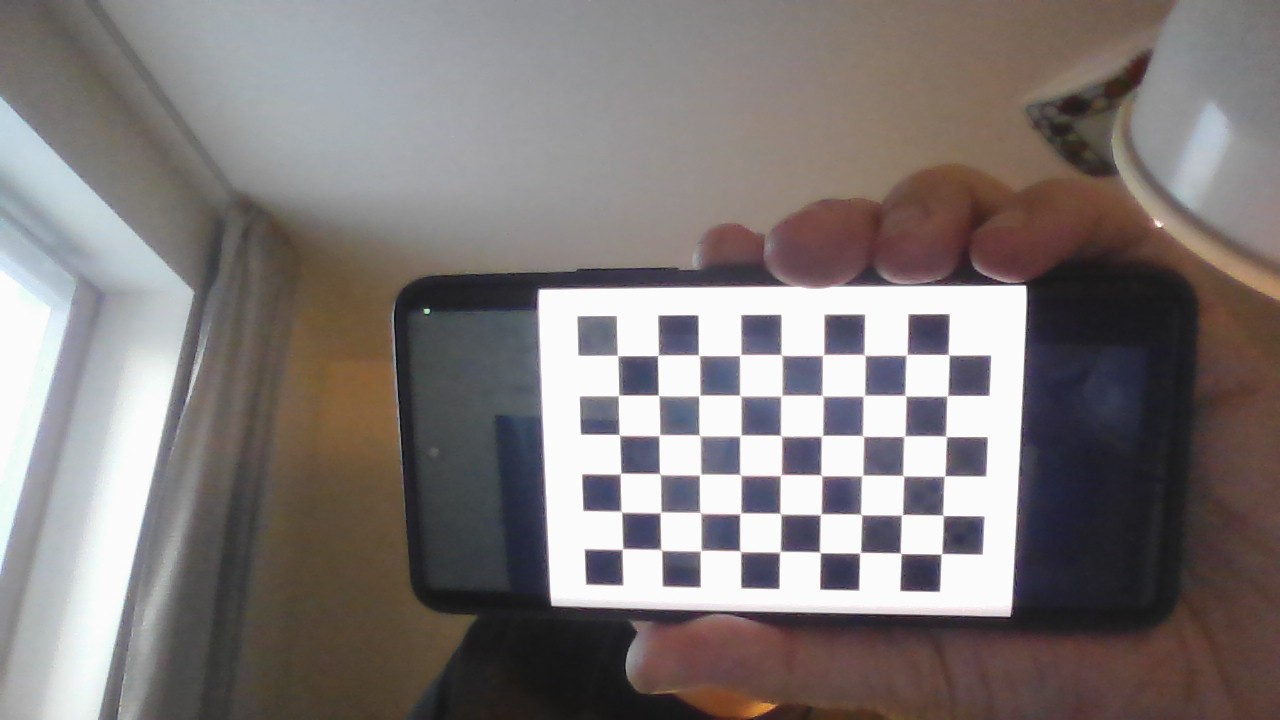

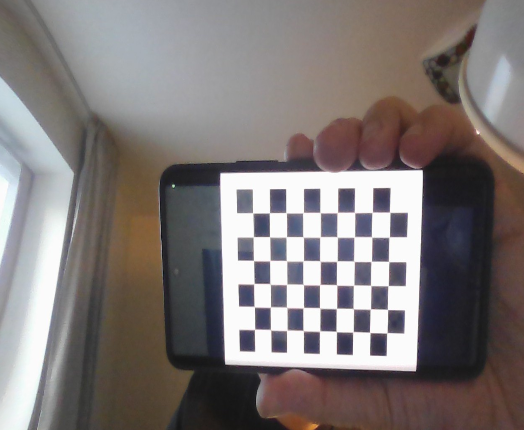

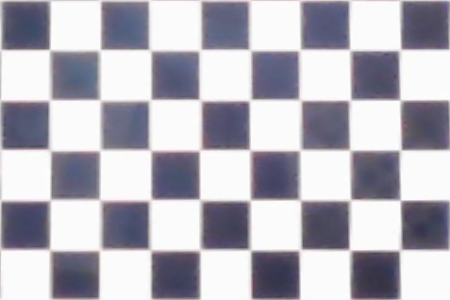

Unwrapped chessboard saved as 'unwrapped_chessboard.jpg'


In [77]:
# Example image path (replace with your actual image containing the chessboard)

img = cv2.imread(images[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 1: Undistort the image using calibration parameters (mtx, dist from earlier)
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
undistorted = cv2.undistort(img, mtx, dist, None, newcameramtx)

# Crop the image if needed (optional, based on ROI)
x, y, w, h = roi
undistorted = undistorted[y:y+h, x:x+w]

# Step 2: Find chessboard corners in the undistorted image
chessboard_size = (9, 6)  # Adjust to your chessboard's inner corners (width, height)
ret, corners = cv2.findChessboardCorners(cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY), chessboard_size, None)

if ret:
    # Refine corners for better accuracy
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    corners = cv2.cornerSubPix(cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY), corners, (11, 11), (-1, -1), criteria)

    # Step 3: Define target points for frontal view (a flat grid in pixels)
    square_size_px = 50  # Pixel size per square in the output (adjust for desired output size)
    dst_pts = np.array([[j * square_size_px, i * square_size_px] for i in range(chessboard_size[1]) for j in range(chessboard_size[0])], dtype='float32')

    # Step 4: Compute homography
    H, _ = cv2.findHomography(corners, dst_pts)

    # Step 5: Warp the undistorted image to frontal view
    output_width = chessboard_size[0] * square_size_px
    output_height = chessboard_size[1] * square_size_px
    unwrapped = cv2.warpPerspective(undistorted, H, (output_width, output_height))

    # Display the results
    cv2_imshow( img)
    cv2_imshow( undistorted)
    cv2_imshow( unwrapped)


    # Optional: Save the unwrapped image
    cv2.imwrite('unwrapped_chessboard.png', unwrapped)
    print("Unwrapped chessboard saved as 'unwrapped_chessboard.jpg'")
else:
    print("Chessboard corners not found in the image!")